## Problem Description

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.



## Problem Statement

Identify which questions asked on Quora are duplicates of questions that have already been asked.

This could be useful to instantly provide answers to questions that have already been answered.

We are tasked with predicting whether a pair of questions are duplicates or not.

Source : Kaggle

## Performance Metric

log-loss : We use log loss as a primary metric as this is a classification problem and we would like to know probabilities as well instead of just plain outcome of 0 and 1

Binary Confusion Matrix : This will be used to calculate precision , recall , TPR , TNR etc


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import os

## EDA

In [2]:
df = pd.read_csv("train.csv")
df.shape

(404290, 6)

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


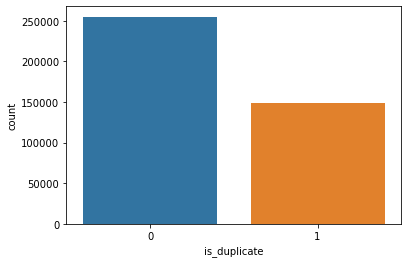

In [5]:
x = df["is_duplicate"]
sns.countplot(x = x )
plt.show()

In [6]:
print(pd.value_counts(df["is_duplicate"]))


0    255027
1    149263
Name: is_duplicate, dtype: int64


In [7]:
print("ratio of 0's as compared to total data is (i.e ratio of non dupicates to total data)" , (255027 / (255027+149263))*100)
print("ratio of 1's to total data (i.e is duplicate)", 149263/(149263+255027)*100)

ratio of 0's as compared to total data is (i.e ratio of non dupicates to total data) 63.08021469737069
ratio of 1's to total data (i.e is duplicate) 36.9197853026293


### No Of Unique Questions

In [8]:
qids = pd.Series(df["qid1"].tolist() + df["qid2"].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts()>1)
print("total number of unique questions are :",unique_qs)
print("number of questions that appear more than one time:",qs_morethan_onetime )
print("max number of times a question is repeated:", max(qids.value_counts()))
q_vals = qids.value_counts()
q_vals = q_vals.values
print(q_vals)
print(qids.value_counts())

total number of unique questions are : 537933
number of questions that appear more than one time: 111780
max number of times a question is repeated: 157
[157 120 111 ...   1   1   1]
2559      157
30782     120
4044      111
2561       88
14376      79
         ... 
212185      1
210136      1
214230      1
220373      1
2047        1
Length: 537933, dtype: int64


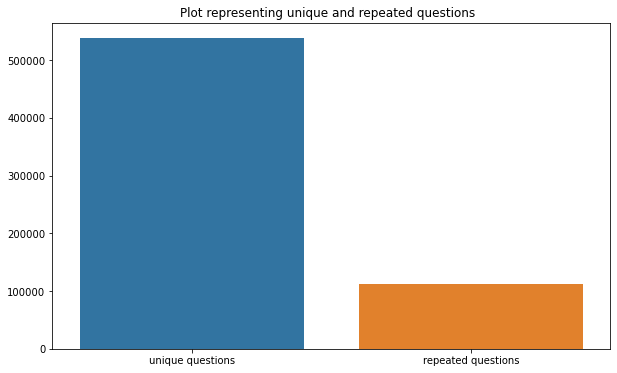

In [9]:
x = ["unique questions" , "repeated questions"]
y = [unique_qs , qs_morethan_onetime]

plt.figure(figsize = (10,6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x = x , y = y)
plt.show()

## Checking for duplicate rows

In [12]:
pair_duplicates = df[["qid1","qid2","is_duplicate"]].groupby(["qid1","qid2"]).count().reset_index()
print("number of duplicate pair in the data are", df.shape[0]-pair_duplicates.shape[0])

number of duplicate pair in the data are 0


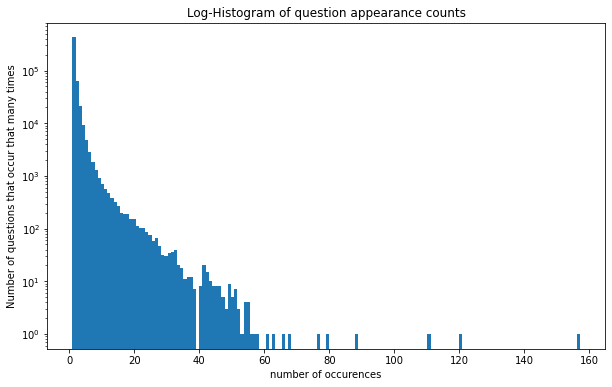

In [13]:
plt.figure(figsize = (10,6))
plt.title('Log-Histogram of question appearance counts')
plt.hist(qids.value_counts(),bins = 160)
plt.yscale("log")
plt.xlabel("number of occurences")
plt.ylabel('Number of questions that occur that many times')
plt.show()

## Checking for null values

In [14]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [15]:
df = df.fillna(" ")
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


## Basic Feature Engineering (before cleaning)

1. freq_qid1 = Frequency of qid1's

2. freq_qid2 = Frequency of qid2's

3. q1len = Length of q1

4. q2len = Length of q2

5. q1_n_words = Number of words in Question 1

6. q2_n_words = Number of words in Question 2

7. word_Common = (Number of common unique words in Question 1 and Question 2)

8. word_Total =(Total num of words in Question 1 + Total num of words in Question 2)

9. word_share = (word_common)/(word_Total)

10. freq_q1+freq_q2 = sum total of frequency of qid1 and qid2

11. freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [50]:
if os.path.isfile("df_fe_without_preprocessing"):
    df = pd.read_csv("df_fe_without_preprocessing", encoding = "latin-1")
    
else:
    df["freq_qid1"] = df.groupby("qid1")["qid1"].transform("count")    
    df["freq_qid2"] = df.groupby("qid2")["qid2"].transform("count")
    df["q1len"] = df["question1"].str.len()
    df["q2len"] = df["question2"].str.len()
    df["q1_n_words"] = df["question1"].apply(lambda row: len(row.split(" ")))
    df["q2_n_words"] = df["question2"].apply(lambda row : len(row.split(" ")))

    def normalized_words_total(row):
        w1 = set(map(lambda word : word.lower().strip() , row["question1"].split(" ")))
        w2 = set(map(lambda word : word.lower().strip() , row["question2"].split(" ")))
        return 1.0 * (len(w1)+len(w2))
    df["word_total"] = df.apply(normalized_words_total, axis = 1)

    def normalized_words_common(row):
        w1 = set(map(lambda words : words.lower().strip() , row["question1"].split(" ")))
        w2 = set(map(lambda words : words.lower().strip() , row["question2"].split(" ")))
        return 1.0 * len(w1 and w2)
    df["word_common"] = df.apply(normalized_words_common , axis = 1)

    def normalized_words_share(row):
         w1 = set(map(lambda word : word.lower().strip() , row["question1"].split(" ")))
         w2 = set(map(lambda word : word.lower().strip() , row["question2"].split(" ")))
         return 1.0 * len(w1 and w2)/(len(w1)+len(w2))
    df["word_share"] = df.apply(normalized_words_share , axis = 1)
        

df["freq_q1+q2"] = df["freq_qid1"] + df["freq_qid2"]
df["freq_q1-q2"] = abs(df["freq_qid1"] - df["freq_qid2"])
    
df.to_csv("df_fe_without_preprocessing",index = False)

df.head()
    
    
        
        






,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_total,word_share,freq_q1+q2,freq_q1-q2,word_common
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,23.0,0.478261,2,0,11.0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,20.0,0.600000,5,3,12.0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,24.0,0.416667,2,0,10.0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,19.0,0.473684,2,0,9.0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,20.0,0.350000,4,2,7.0


## Basic Analysis

In [21]:
print("min length of question in question 1 = ", min(df['q1_n_words']))
print("min length of question in question 2 = ", min(df.q2_n_words))
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== min(df['q1_n_words'])].shape[0])
print("number of questions with minimum length [question2] :" , df[df['q2_n_words'] == min(df['q2_n_words'])].shape[0])


min length of question in question 1 =  1
min length of question in question 2 =  1
Number of Questions with minimum length [question1] : 66
number of questions with minimum length [question2] : 22


## Feature word share

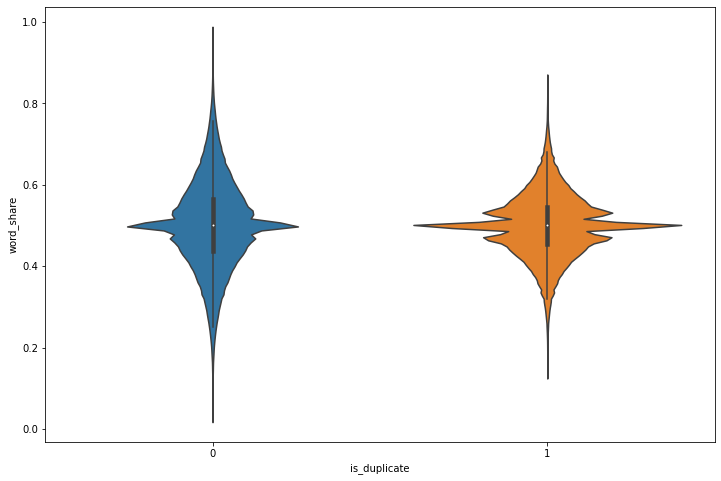

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


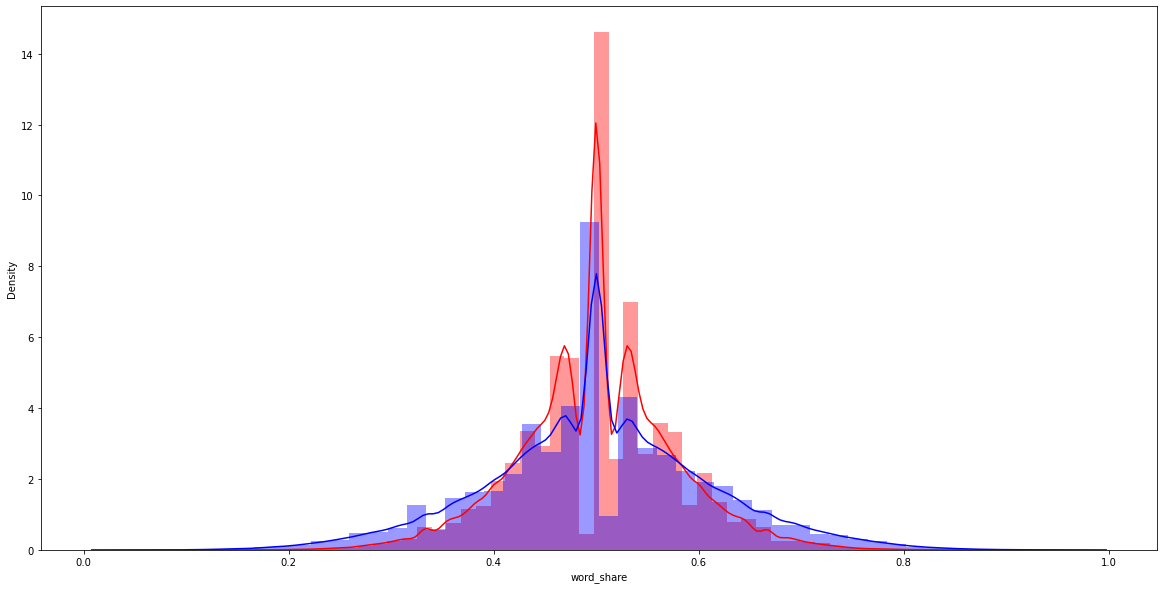

In [45]:
plt.figure(figsize = (12,8))

sns.violinplot(x = df["is_duplicate"] , y = df["word_share"])
plt.show()

plt.figure(figsize = (20,10))

sns.distplot(df[df["is_duplicate"]==1.0]["word_share"][0:],color='red')
sns.distplot(df[df["is_duplicate"]==0.0]["word_share"][0:],color='blue')
plt.show()




## Feature word common

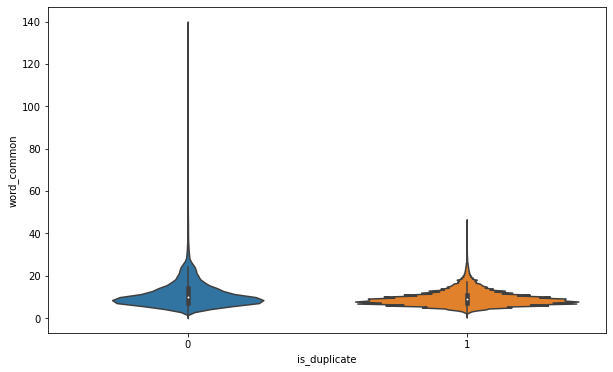

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Acer\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='word_common', ylabel='Density'>

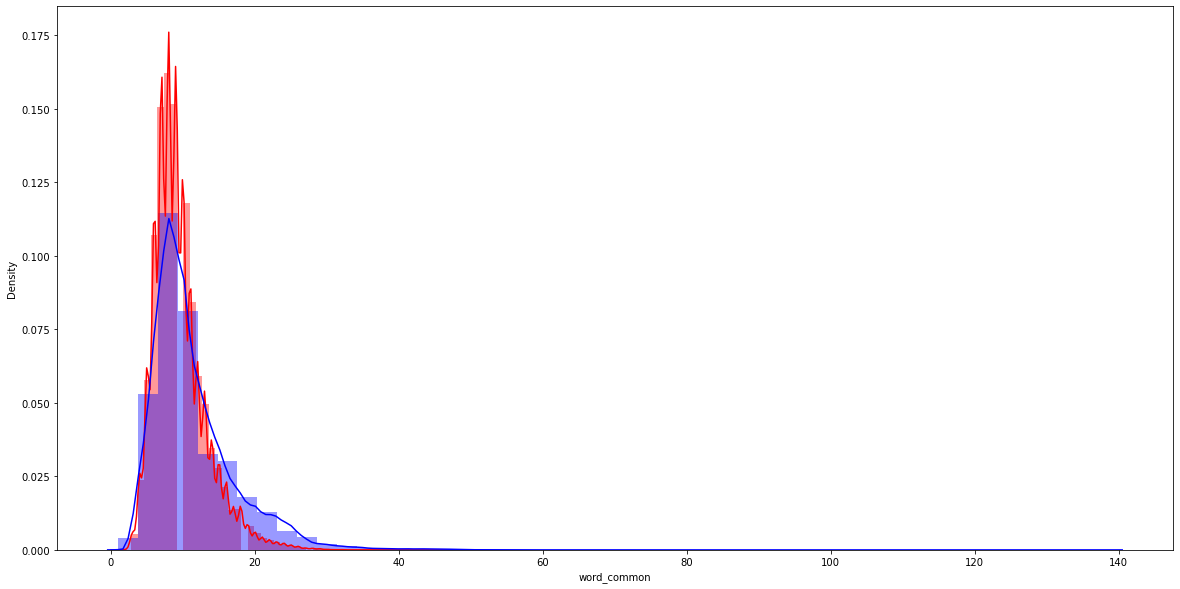

In [56]:
plt.figure(figsize = (10,6))

sns.violinplot(x = df["is_duplicate"] , y = df["word_common"])
plt.show()

plt.figure(figsize = (20,10))
sns.distplot(df[df["is_duplicate"] == 1.0]['word_common'] ,label = "1", color = 'red')
sns.distplot(df[df["is_duplicate"] == 0.0]['word_common'] , label = "1",color = 'blue')